# Efficient simulation of stabilizer circuits with Qiskit Aer primitives

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.3.2
qiskit-ibm-runtime~=0.34.0
qiskit-aer~=0.15.1
qiskit-serverless~=0.18.1
qiskit-ibm-catalog~=0.2
qiskit-addon-sqd~=0.8.1
qiskit-addon-utils~=0.1.0
qiskit-addon-mpf~=0.2.0
qiskit-addon-aqc-tensor~=0.1.2
qiskit-addon-obp~=0.1.0
scipy~=1.15.1
pyscf~=2.8.0; sys.platform != 'win32'
```
</details>

This page shows how to use Qiskit Aer primitives to efficiently simulate stabilizer circuits, including those subject to Pauli noise.

Stabilizer circuits, also known as Clifford circuits, are an important restricted class of quantum circuits that can be efficiently simulated classically. There are several equivalent ways to define stabilizer circuits. One definition is that a stabilizer circuit is a quantum circuit that consists solely of the following gates:

- [CX](../api/qiskit/qiskit.circuit.library.CXGate)
- [Hadamard](../api/qiskit/qiskit.circuit.library.HGate)
- [S](../api/qiskit/qiskit.circuit.library.SGate)
- [Measurement](../api/qiskit/circuit#qiskit.circuit.Measure)

Note that using Hadamard and S, we can construct any Pauli rotation gate ([$R_x$](/api/qiskit/qiskit.circuit.library.RXGate), [$R_y$](/api/qiskit/qiskit.circuit.library.RYGate), and [$R_z$](/api/qiskit/qiskit.circuit.library.RZGate)) that has an angle contained in the set $\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\}$ (up to global phase), so we can include these gates in the definition as well.

Stabilizer circuits are important to the study of quantum error correction. Their classical simulability also makes them useful for verifying the output of quantum computers. For example, suppose you want to execute a quantum circuit that uses 100 qubits on a quantum computer. How do you know that the quantum computer is behaving correctly? A quantum circuit on 100 qubits is beyond the reach of brute-force classical simulation. By modifying your circuit so that it becomes a stabilizer circuit, you can run circuits on the quantum computer that have a similar structure to your desired circuit, but which you can simulate on a classical computer. By checking the output of the quantum computer on the stabilizer circuits, you can gain confidence that it is behaving correctly on the non-stabilizer circuits as well. See [*Evidence for the utility of quantum computing before fault tolerance*](https://www.nature.com/articles/s41586-023-06096-3) for an example of this idea in practice.


[Exact and noisy simulation with Qiskit Aer primitives](simulate-with-qiskit-aer) shows how to use [Qiskit Aer](https://qiskit.org/ecosystem/aer/) to perform exact and noisy simulations of generic quantum circuits. Consider the example circuit used in that article, an 8-qubit circuit built using [EfficientSU2](../api/qiskit/qiskit.circuit.library.EfficientSU2):

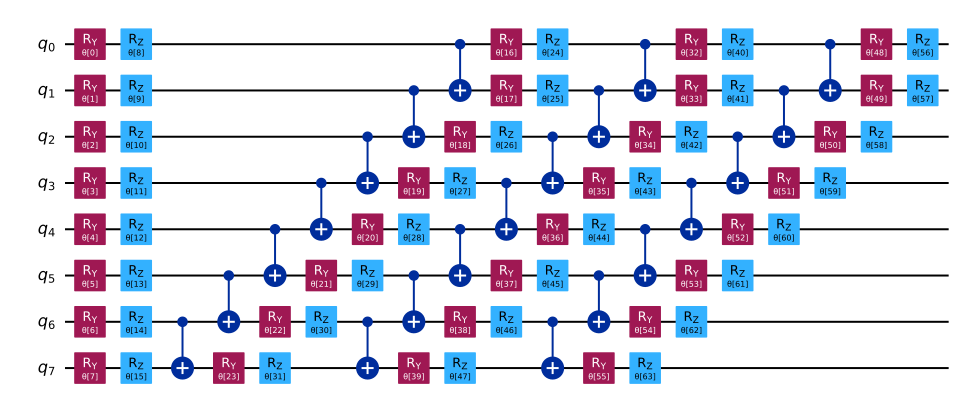

In [1]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 8
circuit = EfficientSU2(n_qubits)
circuit.decompose().draw("mpl")

Using Qiskit Aer, we were able to simulate this circuit easily. However, suppose we set the number of qubits to 500:

In [2]:
n_qubits = 500
circuit = EfficientSU2(n_qubits)
# don't try to draw the circuit because it's too large

Because the cost of simulating quantum circuits scales exponentially with the number of qubits, such a large circuit would generally exceed the capabilities of even a high-performance simulator like Qiskit Aer. Classical simulation of generic quantum circuits becomes infeasible when the number of qubits exceeds roughly 50 to 100 qubits. However, note that the EfficientSU2 circuit is parameterized by angles on $R_y$ and $R_z$ gates. If all of these angles are contained in the set $\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\}$, then the circuit is a stabilizer circuit, and it can be efficiently simulated!

In the following cell, we run the circuit with the Sampler primitive backed by the stabilizer circuit simulator, using parameters chosen randomly such that the circuit is guaranteed to be a stabilizer circuit.

In [3]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

measured_circuit = circuit.copy()
measured_circuit.measure_all()

rng = np.random.default_rng(1234)
params = rng.choice(
    [0, np.pi / 2, np.pi, 3 * np.pi / 2],
    size=circuit.num_parameters,
)

# Initialize a Sampler backed by the stabilizer circuit simulator
exact_sampler = Sampler(
    options=dict(backend_options=dict(method="stabilizer"))
)
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(
    1, AerSimulator(method="stabilizer")
)
isa_circuit = pass_manager.run(measured_circuit)
pub = (isa_circuit, params)
job = exact_sampler.run([pub])
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()

The stabilizer circuit simulator also supports noisy simulation, but only for a restricted class of noise models. Specifically, any quantum noise must be characterized by a [Pauli error](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.pauli_error.html#qiskit_aer.noise.pauli_error) channel. [Depolarizing error](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.depolarizing_error.html) falls into this category, so it can be simulated too. Classical noise channels like [readout error](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.ReadoutError.html) can also be simulated.

The following code cell runs the same simulation as before, but this time specifying a noise model that adds depolarizing error of 2% to each CX gate, as well as readout error that flips each measured bit with 5% probability.

In [4]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
bit_flip_prob = 0.05
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
noise_model.add_all_qubit_readout_error(
    ReadoutError(
        [
            [1 - bit_flip_prob, bit_flip_prob],
            [bit_flip_prob, 1 - bit_flip_prob],
        ]
    )
)

noisy_sampler = Sampler(
    options=dict(
        backend_options=dict(method="stabilizer", noise_model=noise_model)
    )
)
job = noisy_sampler.run([pub])
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()

Now, let's use the Estimator primitive backed by the stabilizer simulator to compute the expectation value of the observable $ZZ \cdots Z$. Due to the special structure of stabilizer circuits, the result is very likely to be 0.

In [5]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as Estimator

observable = SparsePauliOp("Z" * n_qubits)

exact_estimator = Estimator(
    options=dict(backend_options=dict(method="stabilizer")),
)
isa_circuit = pass_manager.run(circuit)
pub = (isa_circuit, observable, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

0.0

## Next steps

<Admonition type="tip" title="Recommendations">
  - To simulate circuits with Qiskit Aer, see [Exact and noisy simulation with Qiskit Aer primitives](./simulate-with-qiskit-sdk-primitives).
  - Review the [Qiskit Aer](https://qiskit.org/ecosystem/aer/) documentation.
</Admonition>